# 1. Data Augmentation With CTGAN

In [1]:
pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 149.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.7 MB/s eta 0:00:00


In [2]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

GPU available: True
Device name: NVIDIA A100-SXM4-40GB


In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Load dataset
cols = [line.strip() for line in open('census-bureau.columns')]

df = pd.read_csv("census-bureau.data", header=None, names=cols)

# Clean data

# Replace "?" with NaN
# Note that we should not replace 'Not in universe' wiht NA
df.replace(['?'], pd.NA, inplace=True)

# Only select positive rows
df = df[df['label'].str.strip() == "50000+."]

# Strip label spaces & unify format
#df["label"] = df["label"].str.strip()
#df["label"] = df["label"].replace({"- 50000.": "<=50K", "50000+.": ">50K"})

# Drop columns with too many missing values
missing_ratio = df.isna().mean()
df = df.drop(columns=missing_ratio[missing_ratio > 0.4].index)

# Fill NaN in categorical with "Unknown", numerical with median
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")
    else:
        df[col] = df[col].fillna(df[col].median())



In [58]:
print(len(df.columns.tolist()))

38


In [59]:
print(df.head())
print(df.info())
print(df.describe())

    age                 class of worker  detailed industry recode  \
57   42      Self-employed-incorporated                        37   
64   47                         Private                        31   
68   33                         Private                        30   
80   58  Self-employed-not incorporated                        35   
88   54                 Not in universe                         0   

    detailed occupation recode                               education  \
57                           2              Some college but no degree   
64                          33                   12th grade no diploma   
68                          33     Associates degree-occup /vocational   
80                          17  Prof school degree (MD DDS DVM LLB JD)   
88                           0                    High school graduate   

    wage per hour enroll in edu inst last wk                     marital stat  \
57              0            Not in universe  Married-civil

In [61]:
# Encode categorical variables (for CTGAN, keep them as categories)
categorical_cols = [
    'class of worker', 'detailed industry recode', 'detailed occupation recode',
    'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code',
    'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union',
    'reason for unemployment', 'full or part time employment stat', 'tax filer stat',
    'region of previous residence', 'state of previous residence',
    'detailed household and family stat', 'detailed household summary in household',
    'live in this house 1 year ago',
    'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self',
    'citizenship', 'own business or self employed', 'fill inc questionnaire for veteran\'s admin',
    'veterans benefits'
]

for col in categorical_cols:
    df[col] = df[col].astype(str)

# Train-test split
train, test = train_test_split(df, test_size=0.01, random_state=42, stratify=df["label"])

In [62]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12258 entries, 22141 to 96735
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         12258 non-null  int64  
 1   class of worker                             12258 non-null  object 
 2   detailed industry recode                    12258 non-null  object 
 3   detailed occupation recode                  12258 non-null  object 
 4   education                                   12258 non-null  object 
 5   wage per hour                               12258 non-null  int64  
 6   enroll in edu inst last wk                  12258 non-null  object 
 7   marital stat                                12258 non-null  object 
 8   major industry code                         12258 non-null  object 
 9   major occupation code                       12258 non-null  object 
 10  race       

Using gpu to train a CTGAN for generating sythetic data.




In [63]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Train CTGAN only on training data
device = "cuda" if torch.cuda.is_available() else "cpu"

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train)

ctgan = CTGANSynthesizer(
    metadata,
    enforce_rounding=False,
    epochs=300,
    verbose=True,
    cuda=True if device=="cuda" else False
)
ctgan.fit(train)

# Save model
ctgan.save('ctgan_income_model.pkl')

/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-2.05) | Discrim. (-0.35): 100%|██████████| 300/300 [06:03<00:00,  1.21s/it]


In [64]:
# Generate synthetic samples for minority class (>50K)
from sdv.sampling import Condition
conditions = Condition(
    num_rows=50000,
    column_values={'label': '50000+.'}
)

minority_samples = ctgan.sample_from_conditions([conditions])

Sampling conditions: 100%|██████████| 50000/50000 [00:02<00:00, 18609.44it/s]


In [65]:
minority_samples = minority_samples[~(minority_samples['age'].astype(int) < 18)]

In [66]:
# Save local
minority_samples.to_csv('synthetic_data.csv', index=False)

In [67]:
# Visualization
#columns = [line.strip() for line in open('census-bureau.columns')]

# Load data
df = pd.read_csv('synthetic_data.csv')

# Quick look
print(df.head())
print(df.info())
print(df.describe())

   age             class of worker  detailed industry recode  \
0   34                     Private                        38   
1   24          Federal government                        33   
2   44  Self-employed-incorporated                        29   
3   39                     Private                        30   
4   48                     Private                        43   

   detailed occupation recode                               education  \
0                           7               Doctorate degree(PhD EdD)   
1                          35              Some college but no degree   
2                          34     Associates degree-occup /vocational   
3                           9  Masters degree(MA MS MEng MEd MSW MBA)   
4                           8              Bachelors degree(BA AB BS)   

   wage per hour enroll in edu inst last wk                     marital stat  \
0              0            Not in universe                    Never married   
1              0

In [68]:
# Restore missing columns
df_org = pd.read_csv("census-bureau.data", header=None, names=cols)
for col in df_org.columns:
    if col not in df.columns:
        if df_org[col].dtype == 'object':
            df[col] = "?"
        else:
            df[col] = 0

In [69]:
df = df[df_org.columns]

In [70]:
# Save local restored data
df.to_csv('synthetic_data_minor_restored.csv', index=False)

# 2. Train with Sythetic Data

In [71]:
import numpy as np
import pandas as pd
import torch

# Visualization
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# Feature Engineering
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelEncoder

# Machine Learning
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Grid Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [128]:
# Load column names
columns = [line.strip() for line in open('census-bureau.columns')]

# Load data
df = pd.read_csv('census-bureau.data', header=None, names=columns, na_values='?')

In [129]:
# change label to 0/1
df['label'] = df['label'].str.strip()
df['label'] = df['label'].apply(lambda x: 1 if x == '50000+.' else 0)

# replace placeholder with NA
#df.replace(['Not in universe', '?', 'Not in universe under 1 year old'], pd.NA, inplace=True)
df.replace(['?'], pd.NA, inplace=True)



In [130]:
synthetic = pd.read_csv('synthetic_data_restored.csv')
median_pos_weight = df[df['label'] == 1]['weight'].median()
print(median_pos_weight)
synthetic['weight'] = 0.8 * median_pos_weight

1684.1


In [131]:
# change label to 0/1
synthetic['label'] = synthetic['label'].str.strip()
synthetic['label'] = synthetic['label'].apply(lambda x: 1 if x == '50000+.' else 0)

# replace placeholder with NA
#df.replace(['Not in universe', '?', 'Not in universe under 1 year old'], pd.NA, inplace=True)
synthetic.replace(['?'], pd.NA, inplace=True)



In [132]:
# get categorical columns
categorical_cols = [
    'class of worker', 'detailed industry recode', 'detailed occupation recode',
    'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code',
    'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union',
    'reason for unemployment', 'full or part time employment stat', 'tax filer stat',
    'region of previous residence', 'state of previous residence',
    'detailed household and family stat', 'detailed household summary in household',
    'migration code-change in msa', 'migration code-change in reg',
    'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt',
    'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self',
    'citizenship', 'own business or self employed', 'fill inc questionnaire for veteran\'s admin',
    'veterans benefits'
]

# one-hot encoding categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, dummy_na=True)

# separate features, target, and weights
X = df_encoded.drop(['label', 'weight'], axis=1)
y = df_encoded['label']
weights = df_encoded['weight']

# train test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42, stratify=y
)



In [133]:
# Encode and concatenate synthetic data
synthetic_encoded = pd.get_dummies(synthetic, columns=categorical_cols, dummy_na=True)

X_synth = synthetic_encoded
y_synth = synthetic_encoded['label']
w_synth = synthetic_encoded['weight']

X_synth = X_synth.drop(['label', 'weight'], axis=1)
X_synth = X_synth.reindex(columns=X_train.columns, fill_value=0)

X_train_combined = pd.concat([X_train, X_synth], ignore_index=True)
y_train_combined = pd.concat([y_train, y_synth], ignore_index=True)
w_train_combined = pd.concat([w_train, w_synth], ignore_index=True)

In [134]:
# Shuffle the combined train data
train_combined = pd.concat([X_train_combined, y_train_combined, w_train_combined], axis=1)
train_combined = train_combined.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_combined = train_combined.drop(['label', 'weight'], axis=1)
y_train_combined = train_combined['label']
w_train_combined = train_combined['weight']

In [115]:
# train a random forest classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(X_train_combined, y_train_combined, sample_weight=w_train_combined)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     37429
           1       0.74      0.37      0.49      2476

    accuracy                           0.95     39905
   macro avg       0.85      0.68      0.73     39905
weighted avg       0.95      0.95      0.95     39905

ROC AUC: 0.9405972600432023


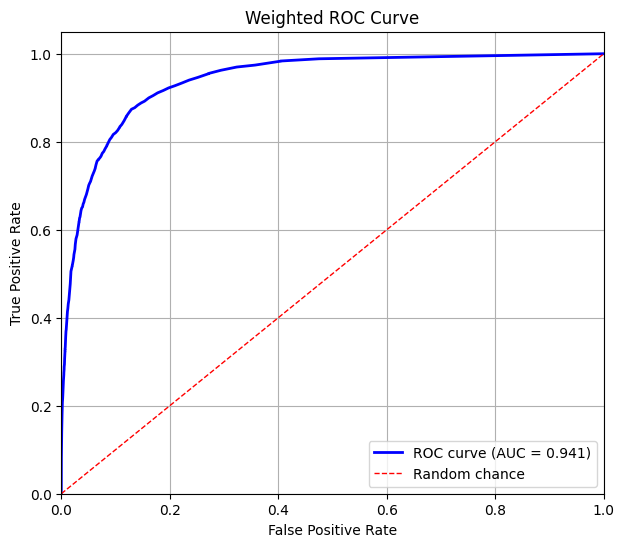

In [116]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=w_test)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [140]:
# Linear Regression
lr_clf = LogisticRegression(
    class_weight='balanced',  # handle imbalance
    max_iter=1000,
    random_state=42
)

lr_clf.fit(X_train_combined, y_train_combined, sample_weight=w_train_combined)

y_pred = lr_clf.predict(X_test)
y_prob = lr_clf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     37429
           1       0.49      0.61      0.54      2476

    accuracy                           0.94     39905
   macro avg       0.73      0.79      0.76     39905
weighted avg       0.94      0.94      0.94     39905

ROC AUC: 0.9359188486387682


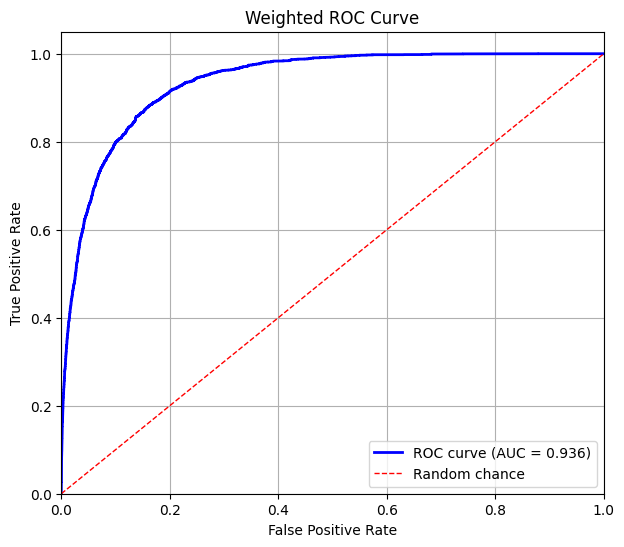

In [141]:
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=w_test)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [138]:
# XGB
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),  # handle imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_clf.fit(X_train_combined.values, y_train_combined.values, sample_weight=w_train_combined.values)


In [142]:
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     37429
           1       0.33      0.88      0.48      2476

    accuracy                           0.88     39905
   macro avg       0.66      0.88      0.70     39905
weighted avg       0.95      0.88      0.90     39905

ROC AUC: 0.9523640525539344


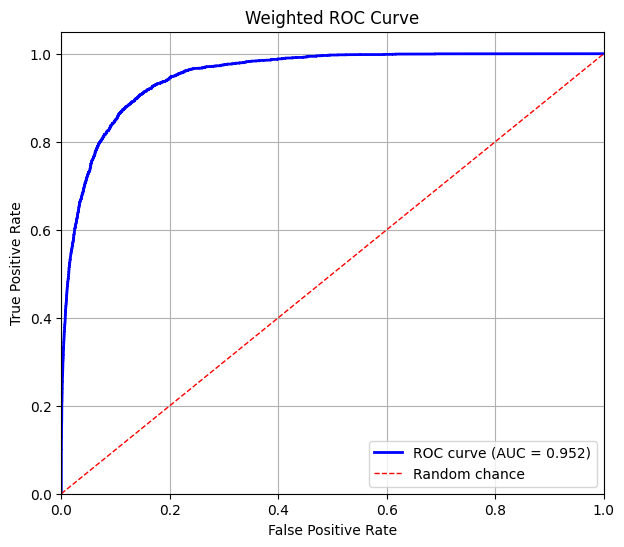

In [143]:
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=w_test)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [144]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=100,
    random_state=42
)

mlp_clf.fit(X_train_combined, y_train_combined)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)

In [145]:
y_pred = mlp_clf.predict(X_test)
y_prob = mlp_clf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     37429
           1       0.65      0.48      0.55      2476

    accuracy                           0.95     39905
   macro avg       0.81      0.73      0.76     39905
weighted avg       0.95      0.95      0.95     39905

ROC AUC: 0.9387356417431778


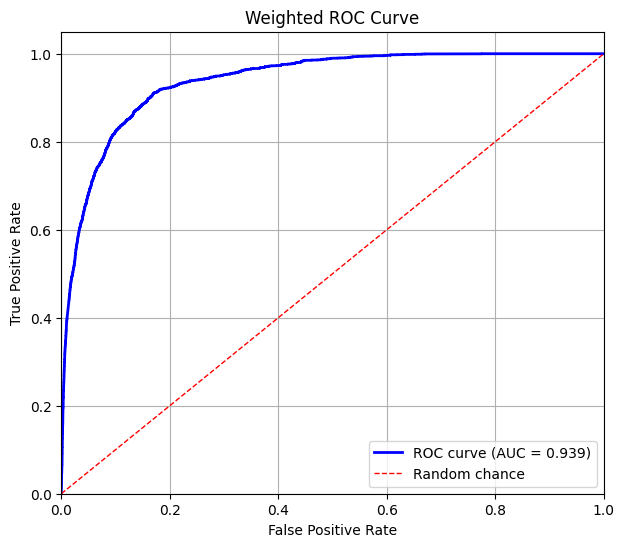

In [146]:
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=w_test)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 3. Evaluation Results for 4 Classifiers

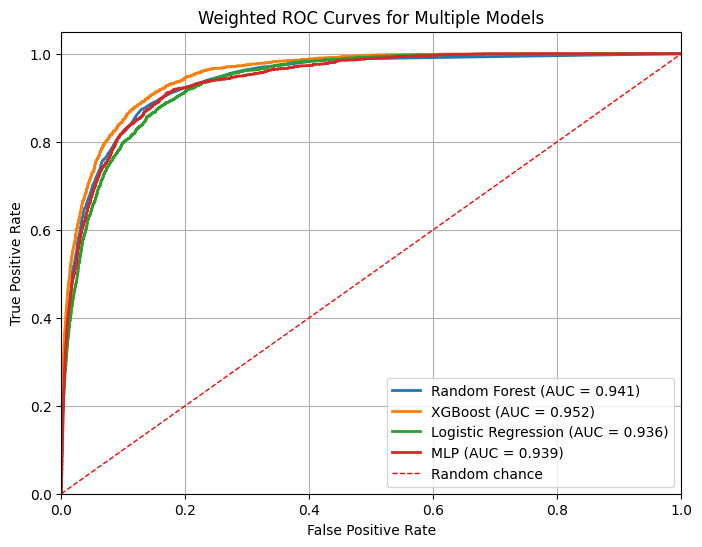

In [147]:
models = {
    "Random Forest": clf,
    "XGBoost": xgb_clf,
    "Logistic Regression": lr_clf,
    "MLP": mlp_clf
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob, sample_weight=w_test)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Plot random chance line
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curves for Multiple Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [150]:
summary_aug = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'XGBoost', 'MLP'],
    'Precision (pos)': [0.74, 0.49, 0.33, 0.65],
    'Recall (pos)': [0.37, 0.61, 0.88, 0.48],
    'F1-score (pos)': [0.49, 0.54, 0.48, 0.55],
    'Accuracy': [0.95, 0.94, 0.88, 0.95],
    'Macro F1': [0.73, 0.76, 0.70, 0.76],
    'ROC-AUC': [0.941, 0.936, 0.952, 0.939]  # Fill with actual ROC-AUC if you computed it
})

summary_aug

,Model,Precision (pos),Recall (pos),F1-score (pos),Accuracy,Macro F1,ROC-AUC
0,Random Forest,0.74,0.37,0.49,0.95,0.73,0.941
1,Logistic Regression,0.49,0.61,0.54,0.94,0.76,0.936
2,XGBoost,0.33,0.88,0.48,0.88,0.70,0.952
3,MLP,0.65,0.48,0.55,0.95,0.76,0.939
